## 1. Importación de bibliotecas y configuración inicial ##

In [109]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder


import warnings

# Configuración inicial
pd.set_option('display.max_columns', None)  # Para mostrar todas las columnas del dataframe
warnings.filterwarnings('ignore')  # Para ignorar advertencias


## 2. Carga y exploración inicial de los datos ##

In [110]:
df = pd.read_excel(r"C:\Users\Usuari\Downloads\regression_data.xls")

Verificación de tipo de datos y conversión de variables categóricas

In [111]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [112]:

# Convertir 'zipcode' a tipo categórico
df['zipcode'] = df['zipcode'].astype('category')

# Verificar los tipos de datos
print(df.dtypes)



id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object


Identificación de valores nulos y manejo de duplicados

In [113]:
# Verificación de valores nulos
df.isna().sum()

# Verificación de duplicados
duplicates = df[df.duplicated(subset='id', keep=False)]

# Si hay duplicados
if not duplicates.empty:
    df.drop_duplicates(subset='id', keep='first', inplace=True)


## 3. Análisis exploratorio de datos (EDA) ##

In [114]:
# Descripción estadística
df.describe()


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price
count,2.142000e+04,21420,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04
mean,4.580940e+09,2014-10-28 05:03:51.932773120,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.007610,0.235107,3.410784,7.662792,1791.170215,291.962418,1971.092997,84.793091,47.560197,-122.213784,1988.384080,12775.718161,5.407393e+05
min,1.000102e+06,2014-05-02 00:00:00,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123537e+09,2014-07-21 00:00:00,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,47.471200,-122.328000,1490.000000,5100.000000,3.225000e+05
50%,3.904921e+09,2014-10-15 00:00:00,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.572100,-122.230000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,2015-02-13 00:00:00,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,560.000000,1997.000000,0.000000,47.678100,-122.125000,2370.000000,10086.250000,6.450000e+05
max,9.900000e+09,2015-05-27 00:00:00,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06
std,2.876761e+09,NaN,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.086903,0.767165,0.650035,1.171971,828.692965,442.875502,29.387141,402.574626,0.138589,0.140791,685.537057,27345.621867,3.679311e+05


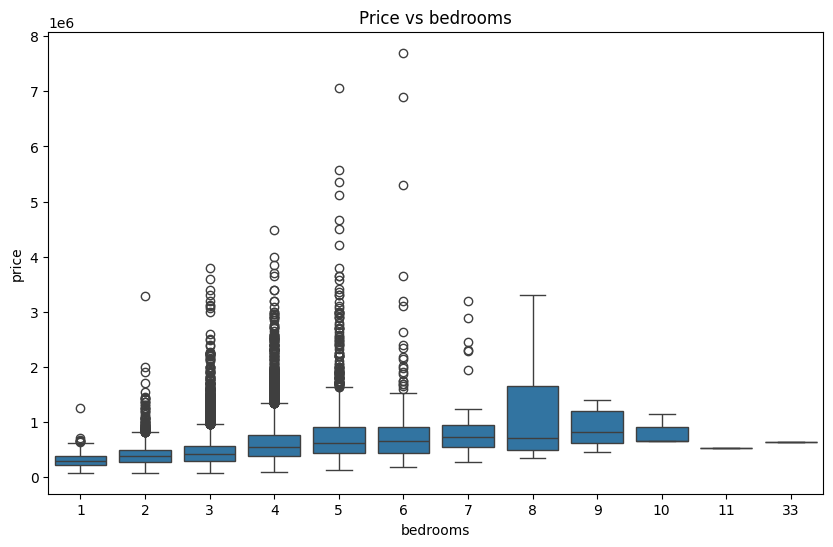

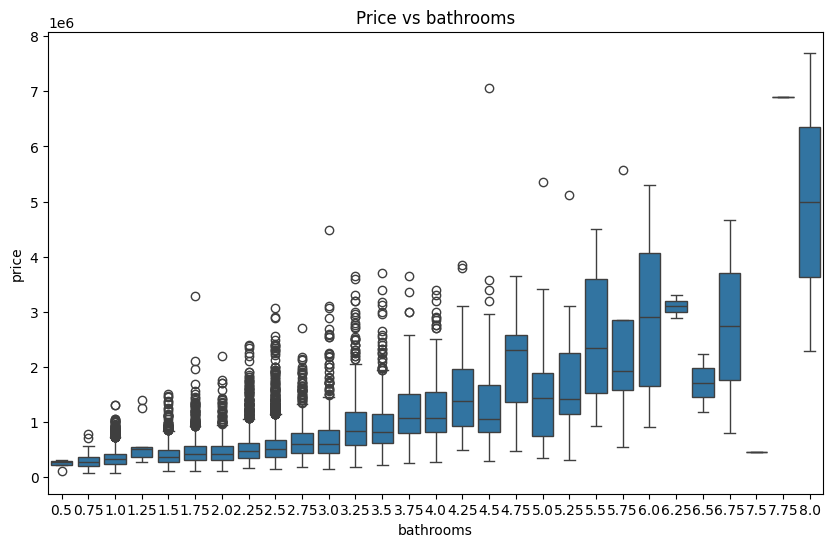

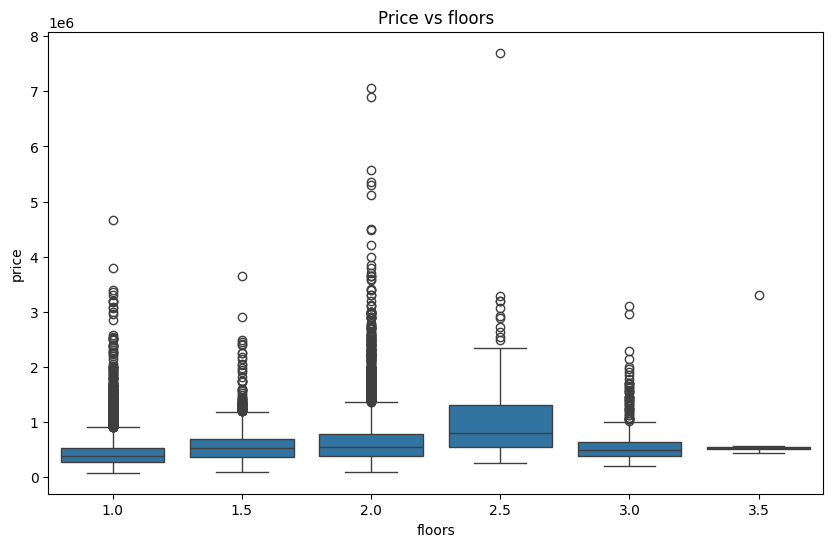

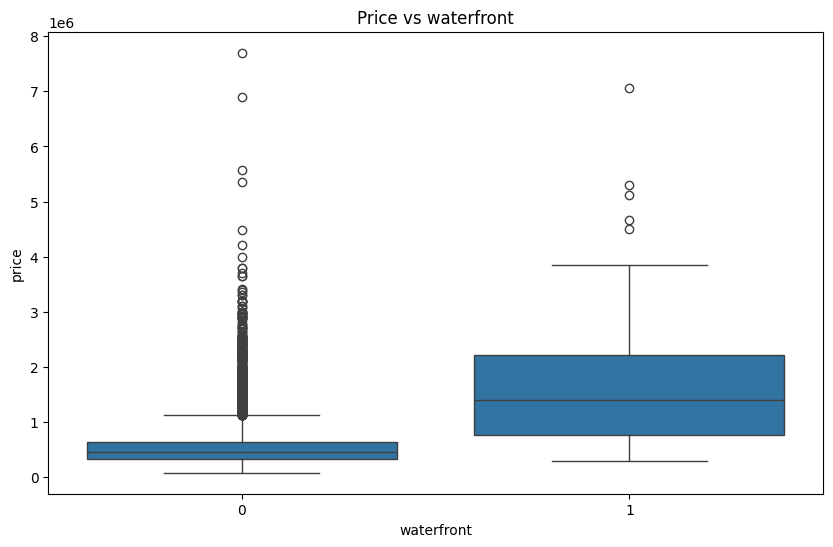

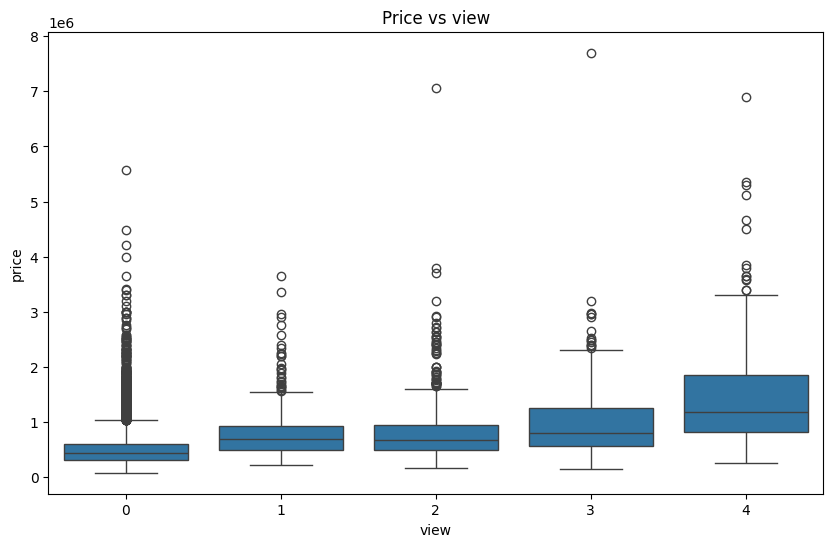

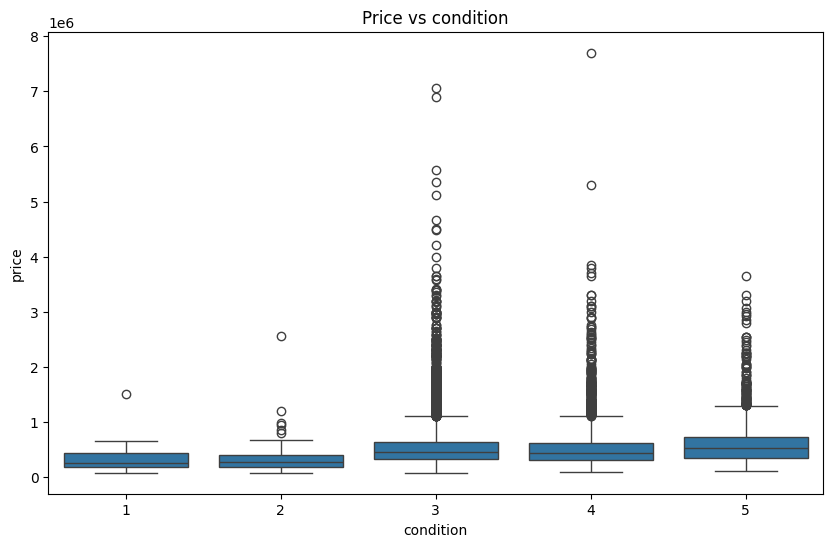

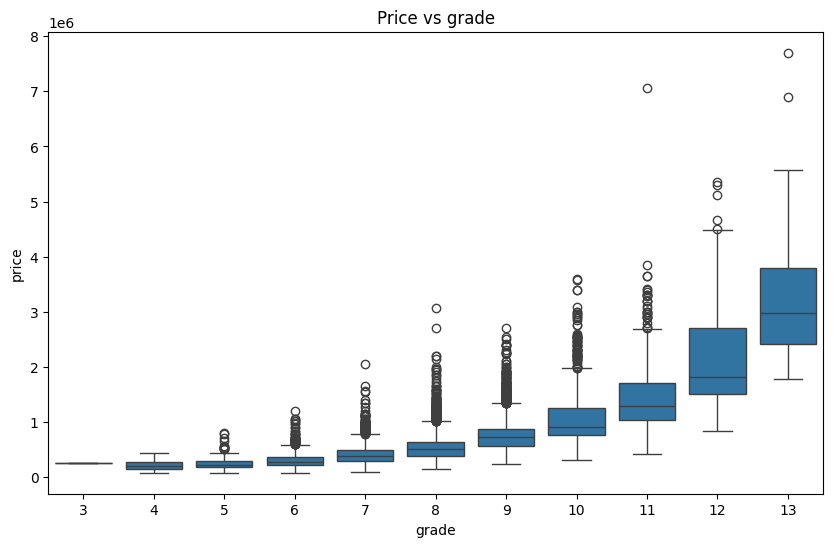

In [115]:
# Gráficos de variables categóricas en relación al precio
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f'Price vs {feature}')
    plt.show()


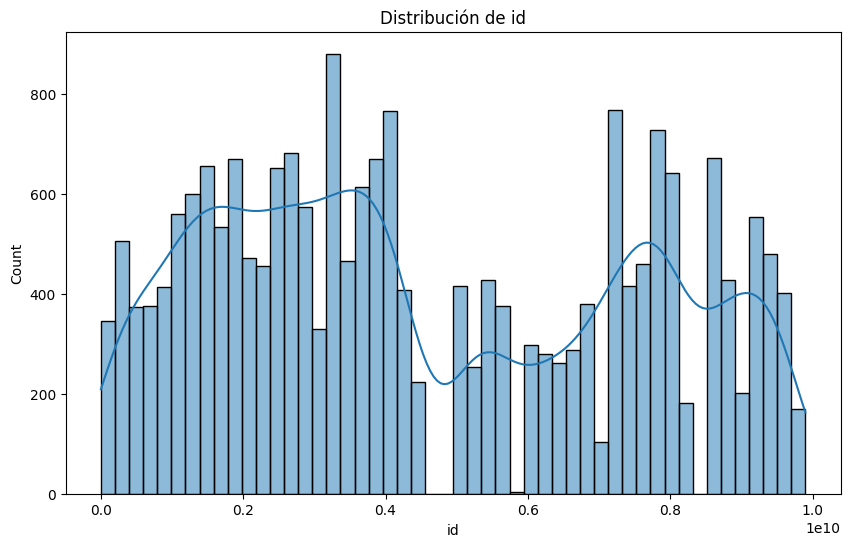

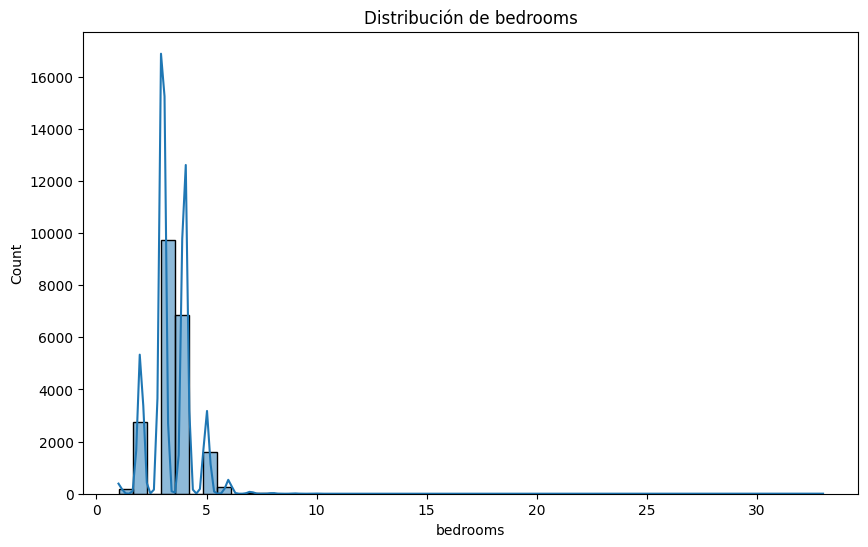

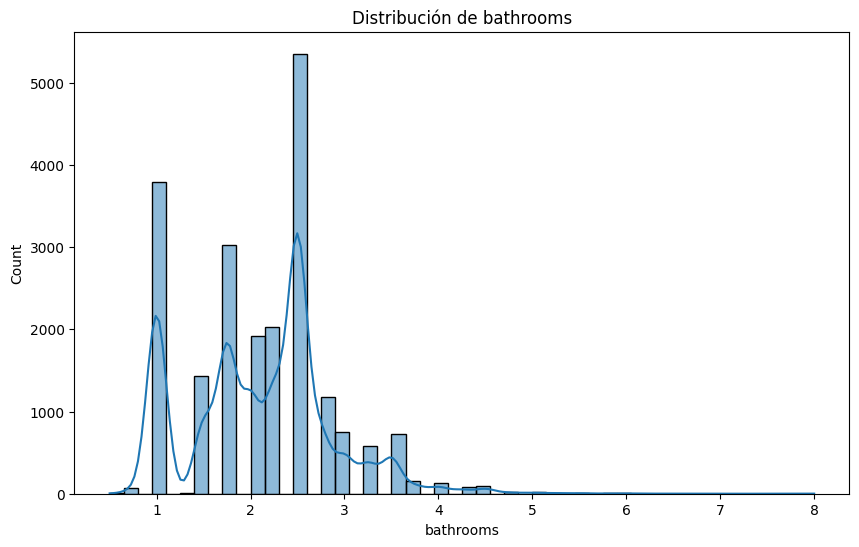

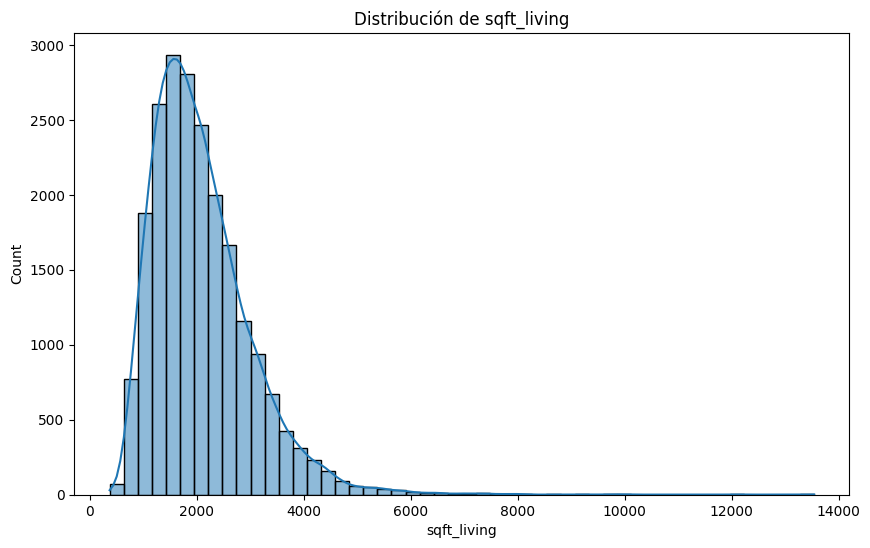

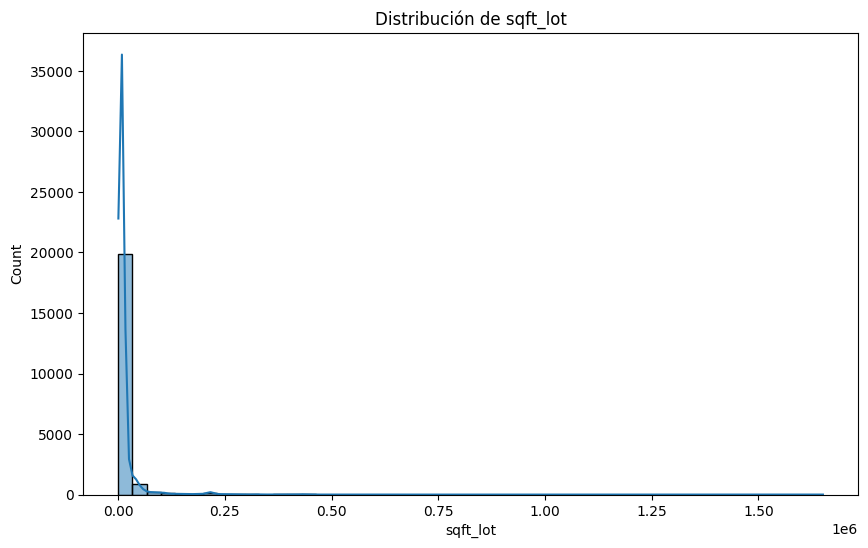

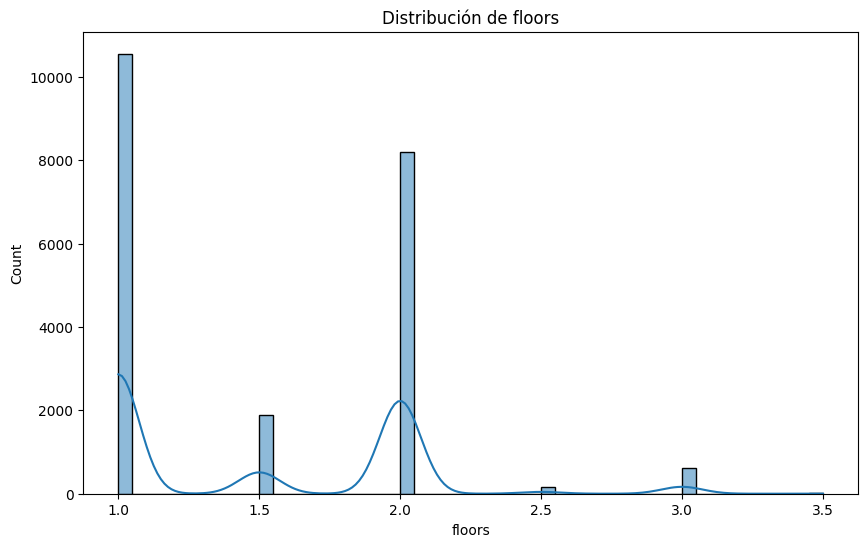

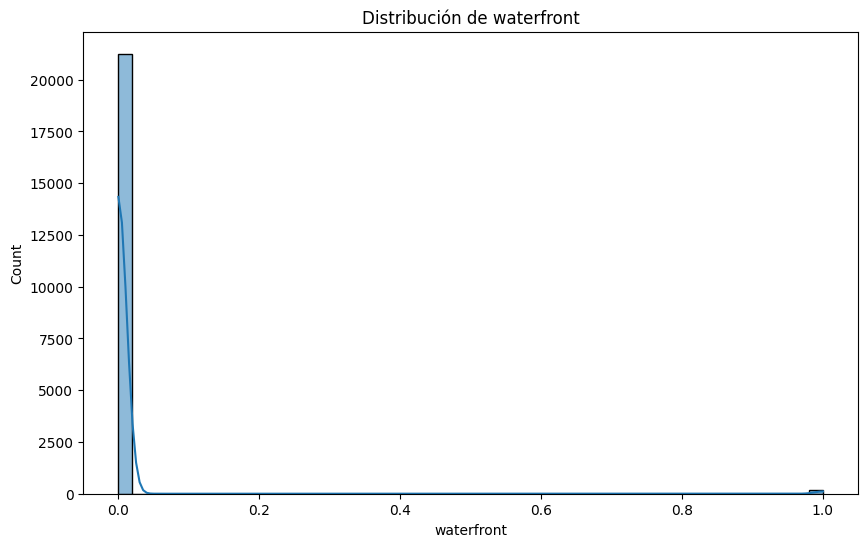

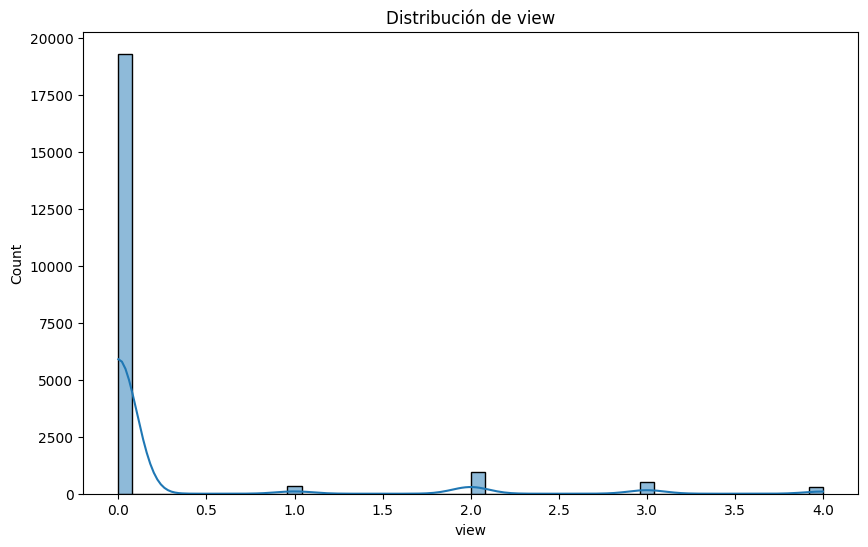

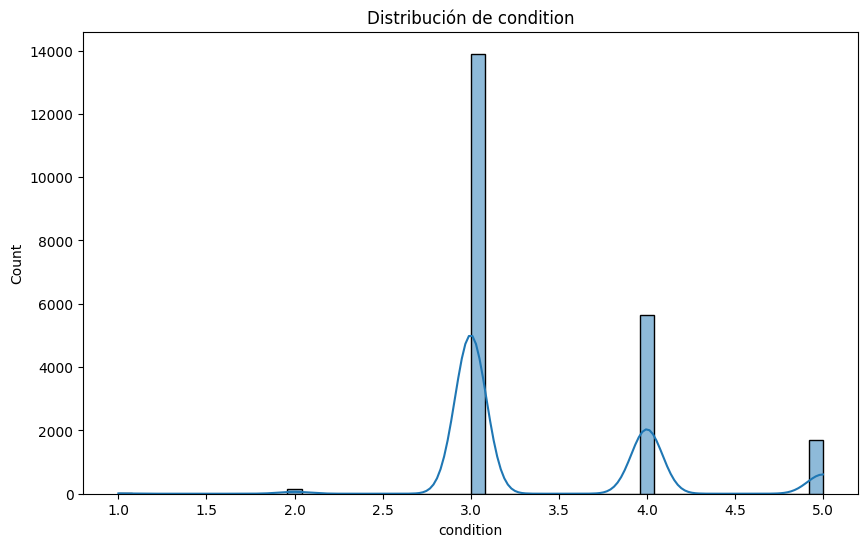

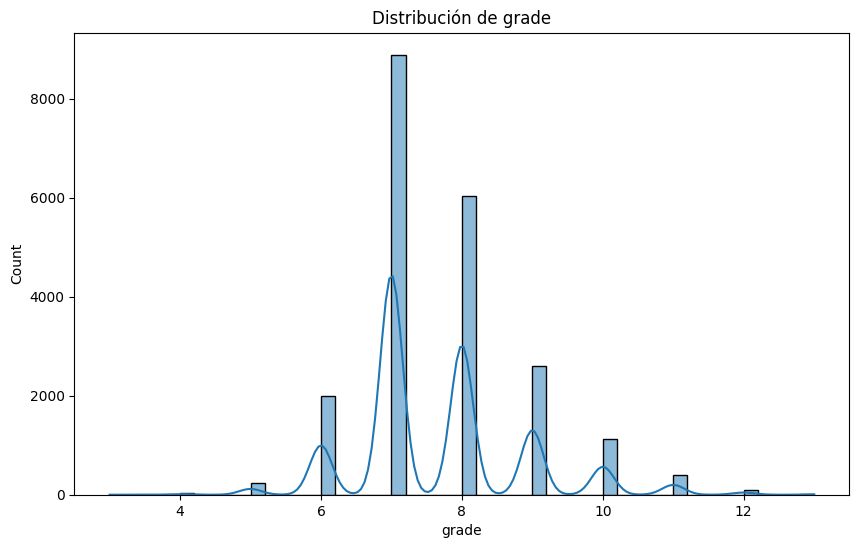

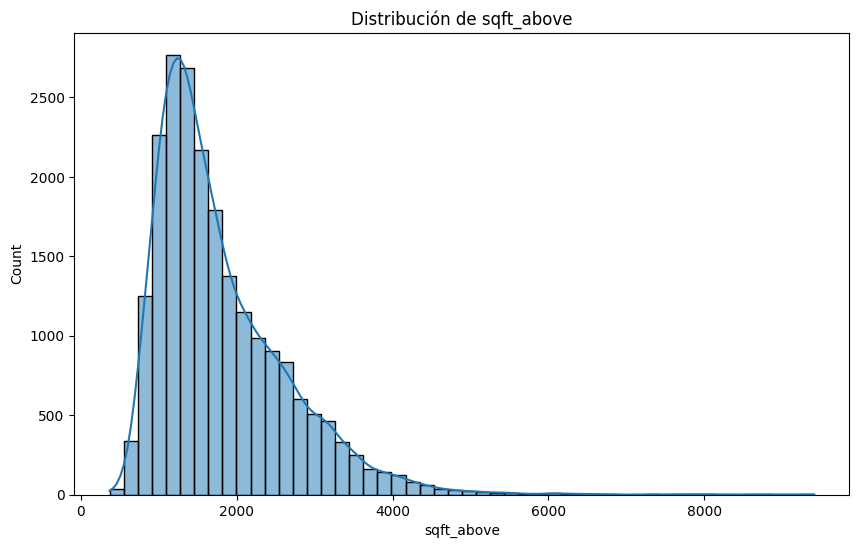

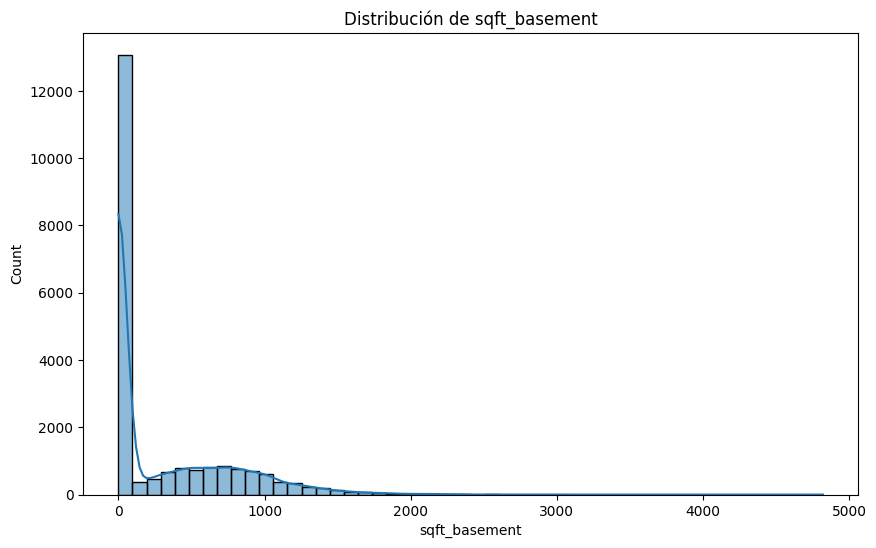

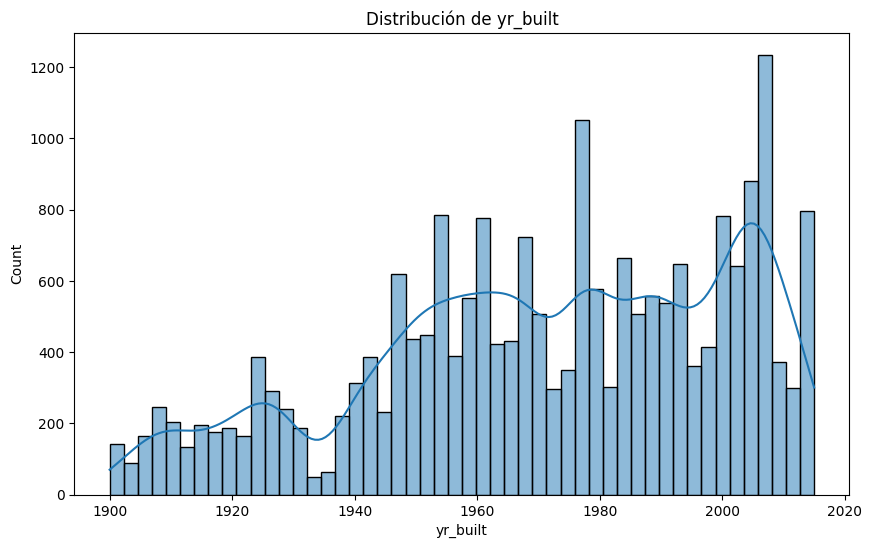

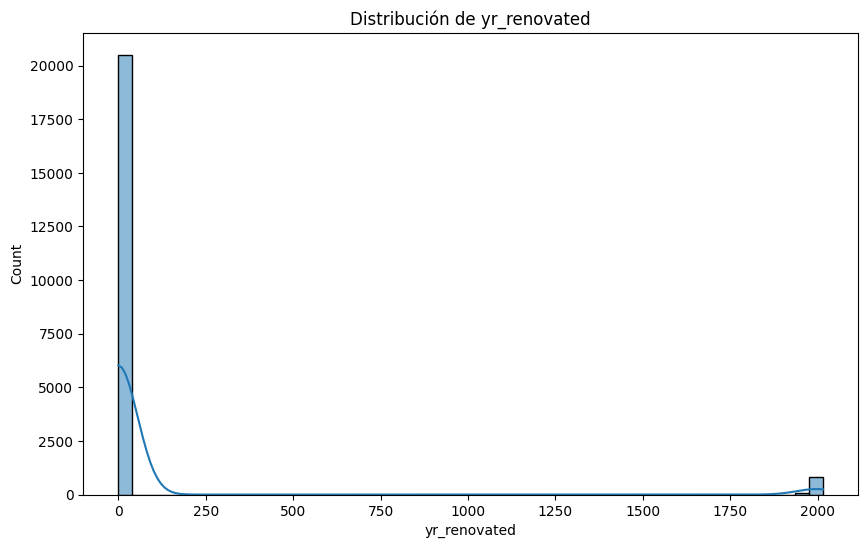

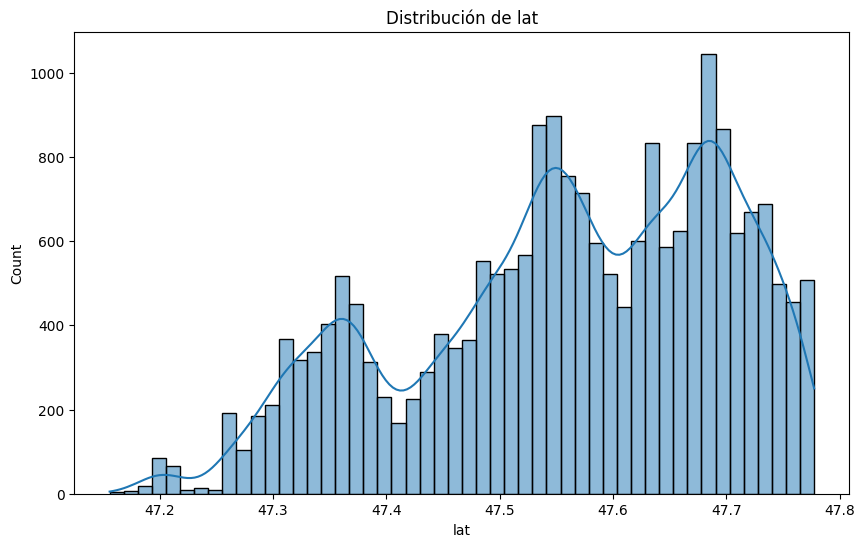

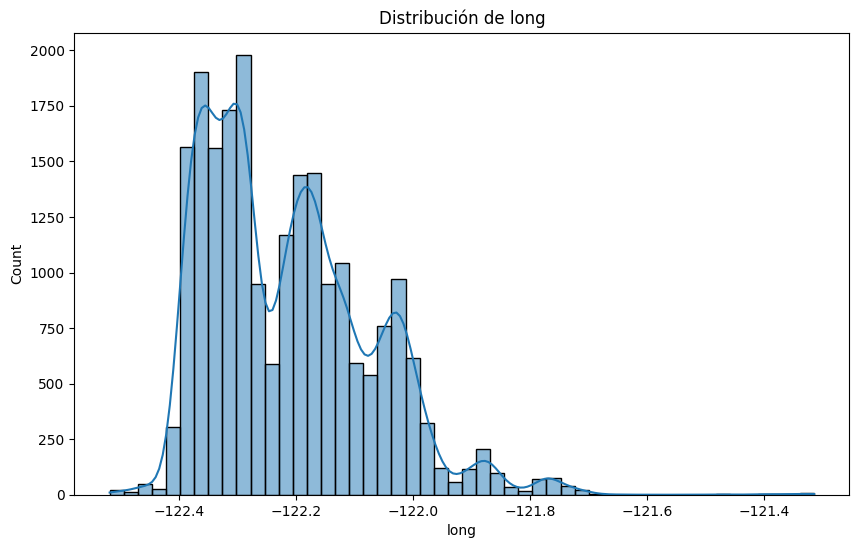

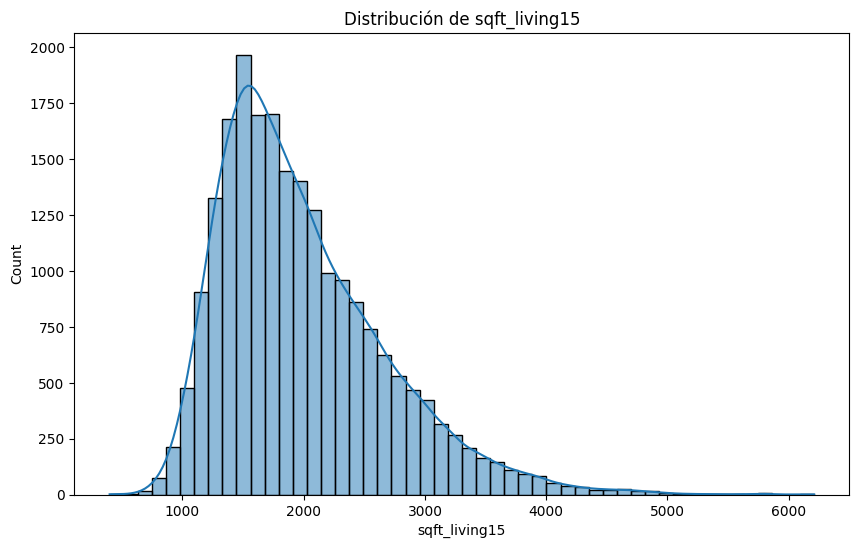

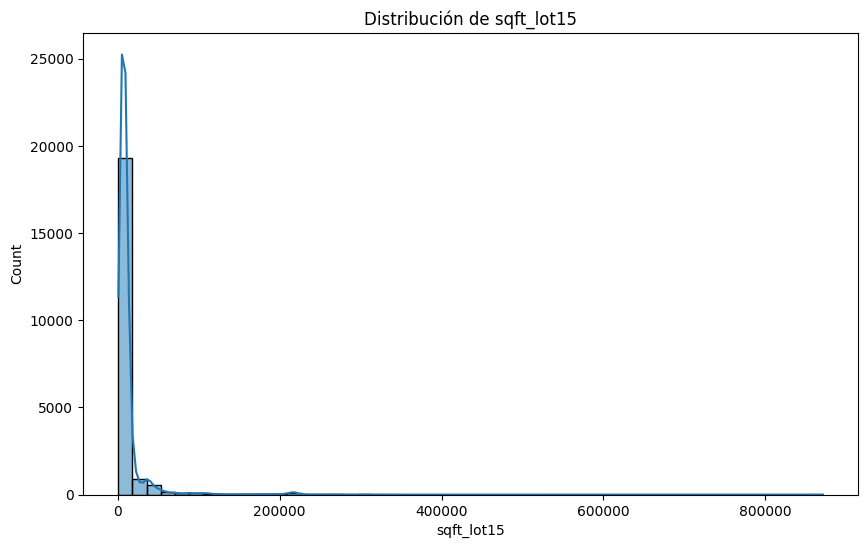

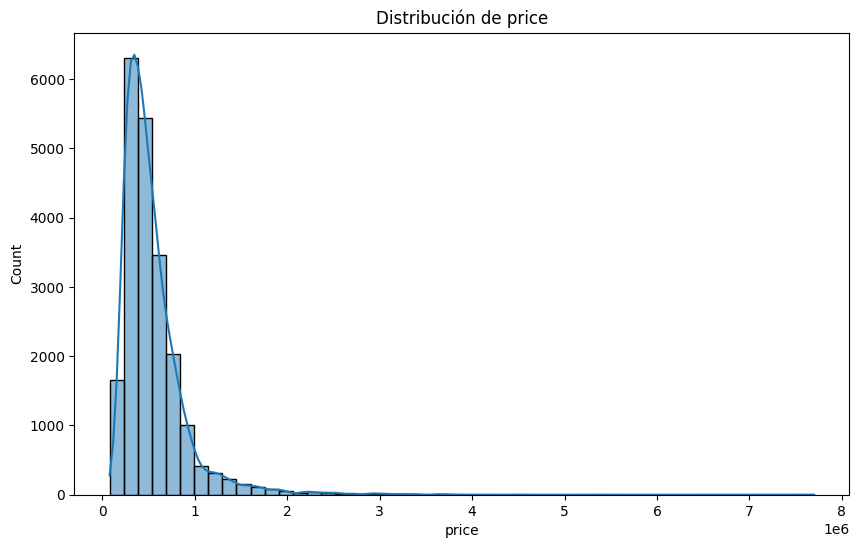

In [116]:
# Visualización de distribuciones
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


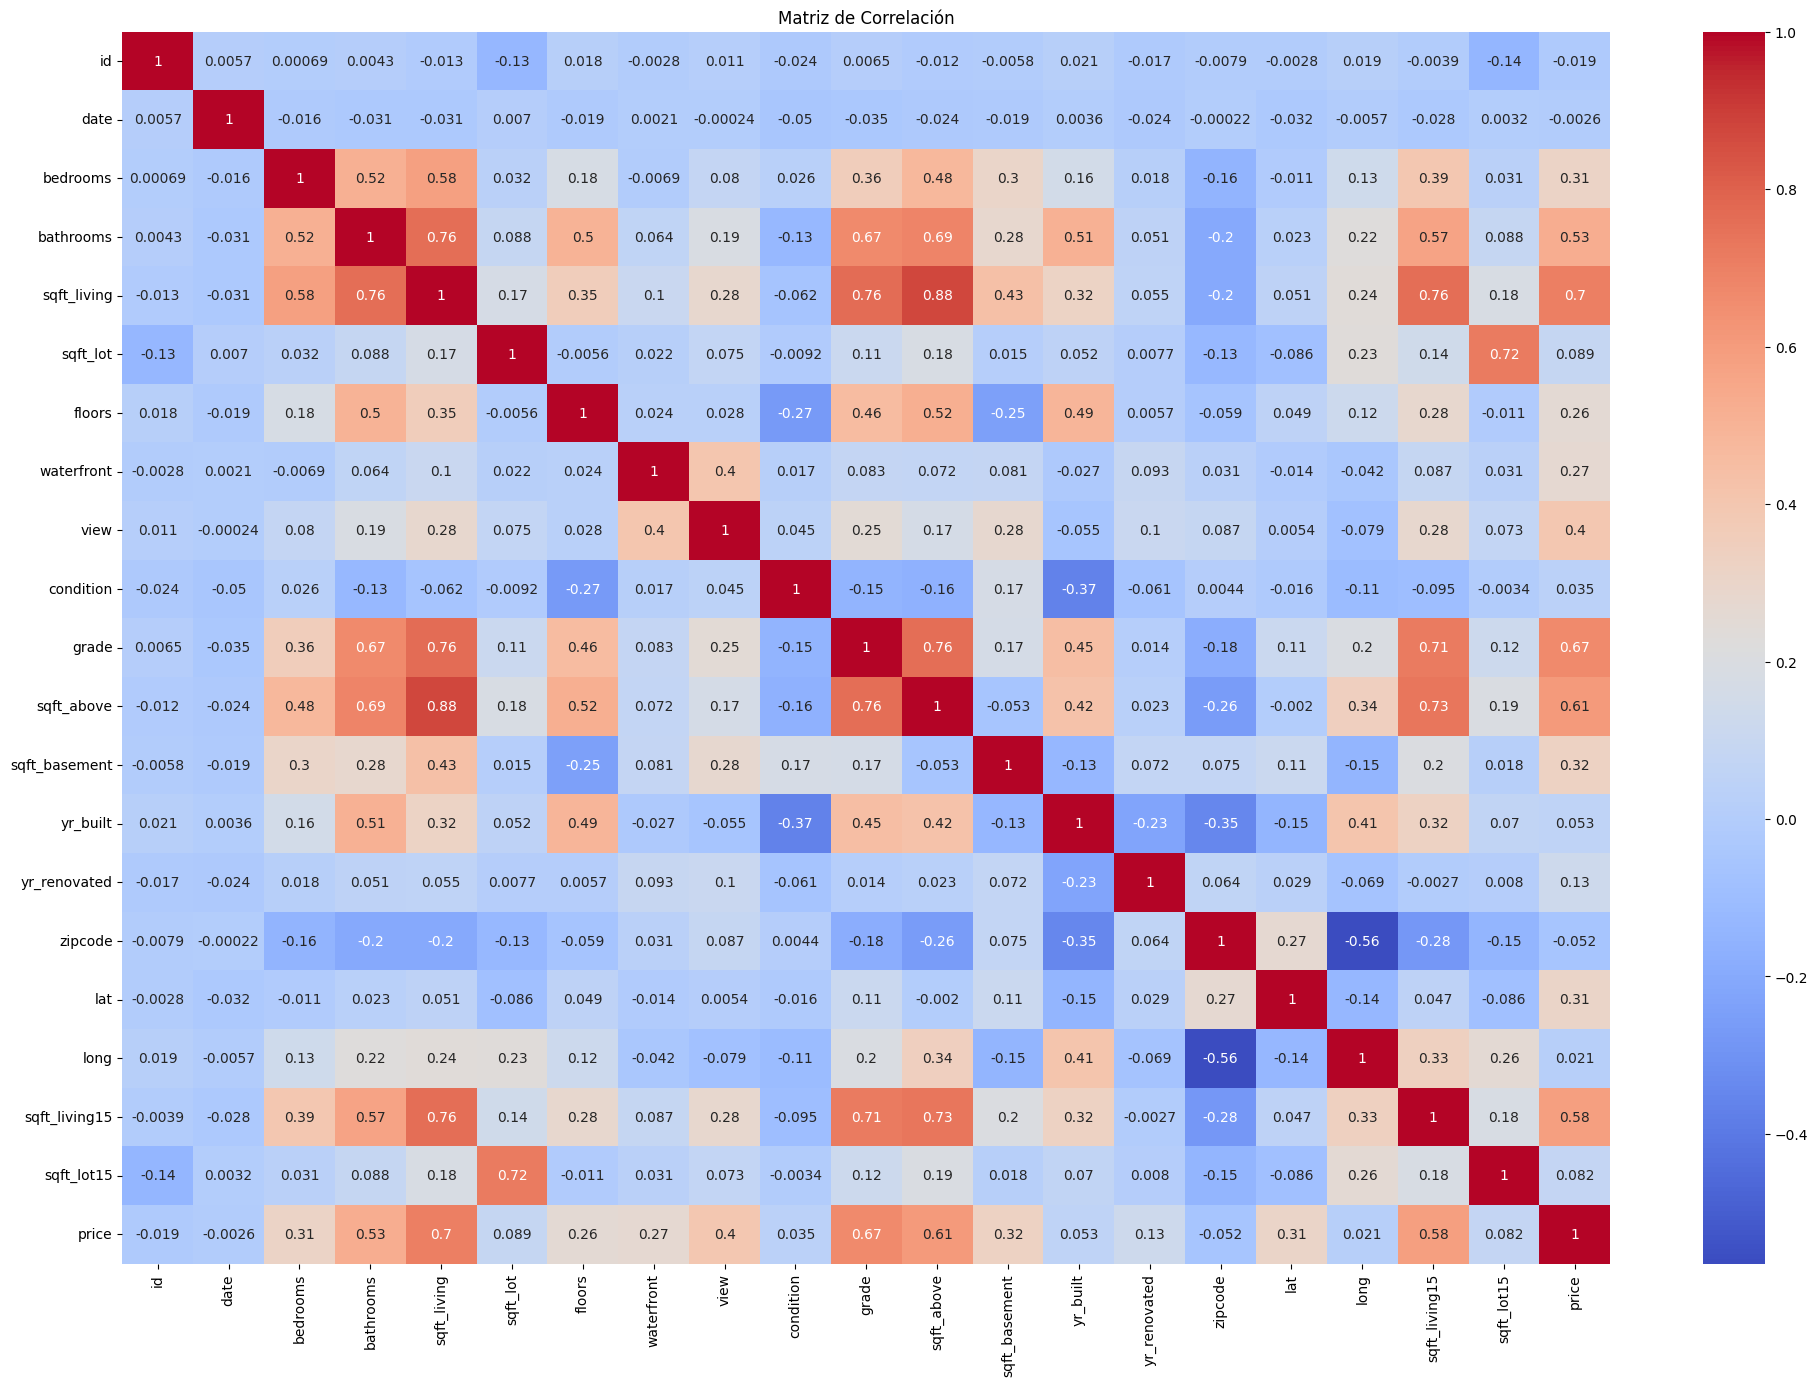

In [117]:
# Matriz de correlación
correlations_matrix = df.corr()
plt.figure(figsize=(24, 16))
sns.heatmap(correlations_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


## 4. Transformación de datos ##

In [118]:
import numpy as np

# Función para identificar outliers
def identificar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]
    return outliers

# Variables numéricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Identificar outliers en cada columna numérica
outliers_dict = {}
for columna in columnas_numericas:
    outliers_dict[columna] = identificar_outliers(df, columna)

# Mostrar el número de outliers por columna
for columna, outliers in outliers_dict.items():
    print(f"{columna}: {len(outliers)} outliers")


id: 0 outliers
bedrooms: 518 outliers
bathrooms: 558 outliers
sqft_living: 568 outliers
sqft_lot: 2406 outliers
floors: 0 outliers
waterfront: 163 outliers
view: 2114 outliers
condition: 28 outliers
grade: 1889 outliers
sqft_above: 600 outliers
sqft_basement: 493 outliers
yr_built: 0 outliers
yr_renovated: 910 outliers
lat: 2 outliers
long: 252 outliers
sqft_living15: 503 outliers
sqft_lot15: 2174 outliers
price: 1151 outliers


Hemos encontrado outliers en varias características que pueden ser importantes, así que vamos a aplicar una transformación logarítmica.

Tratamiento de los outliers: transformación logarítmica

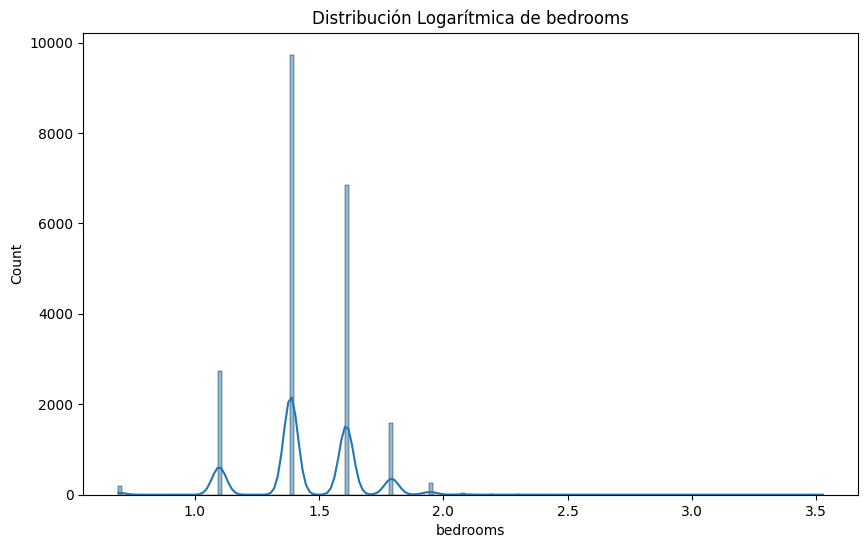

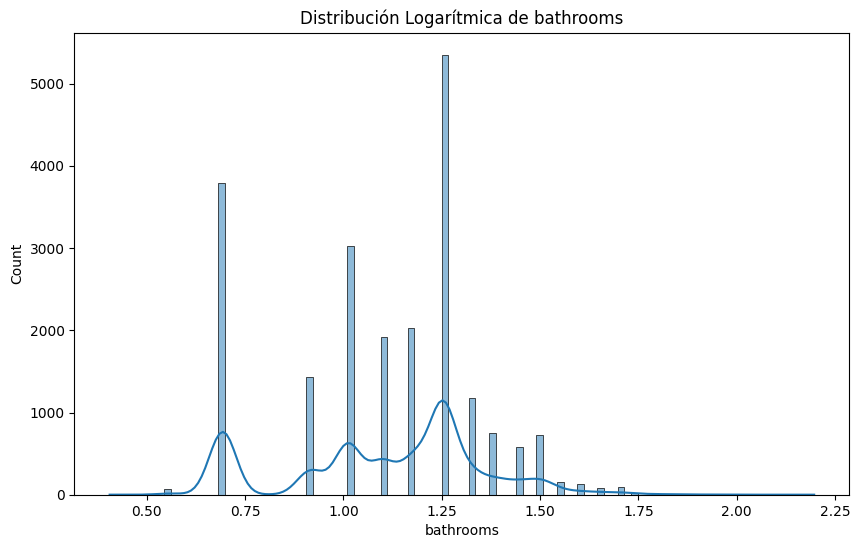

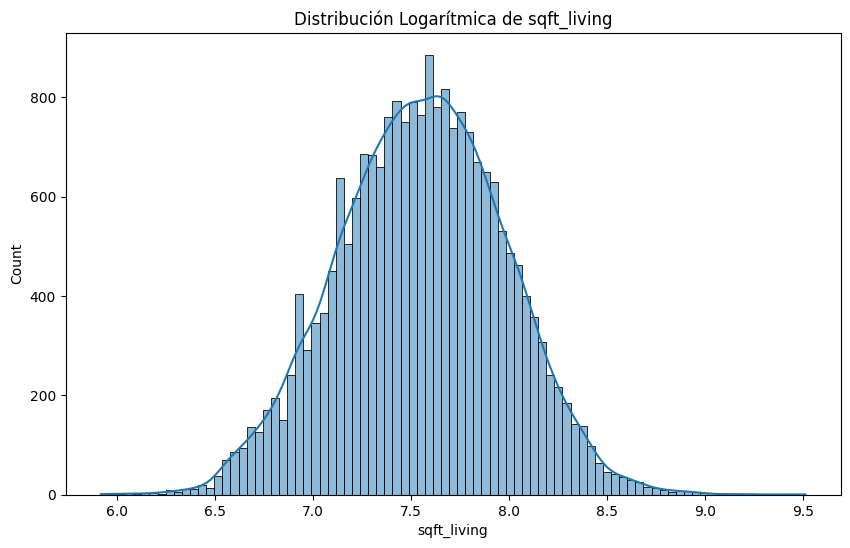

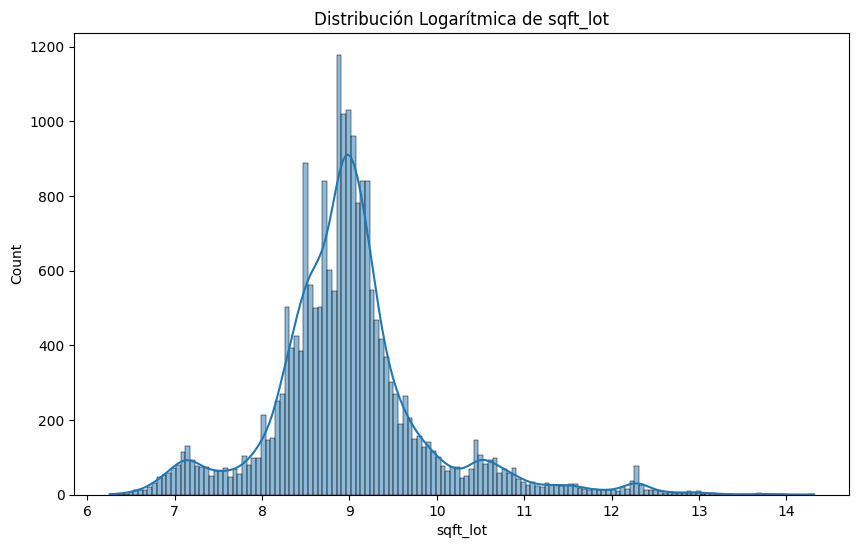

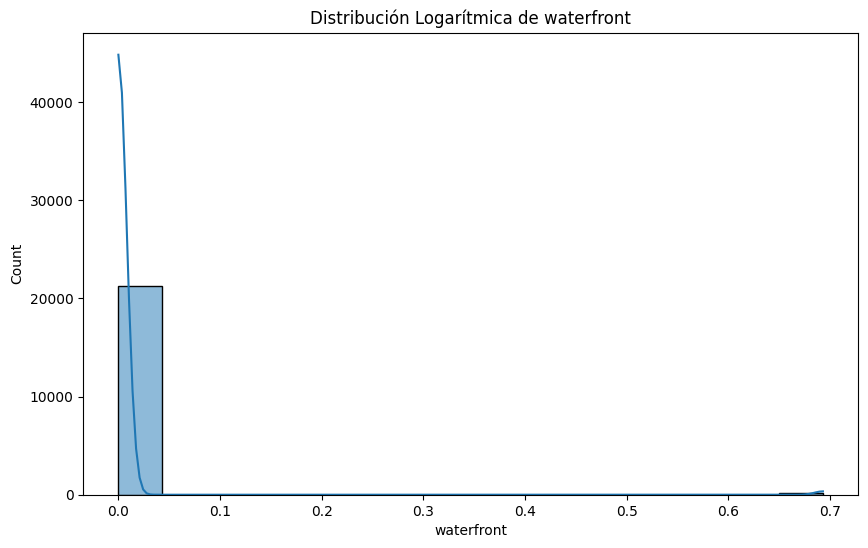

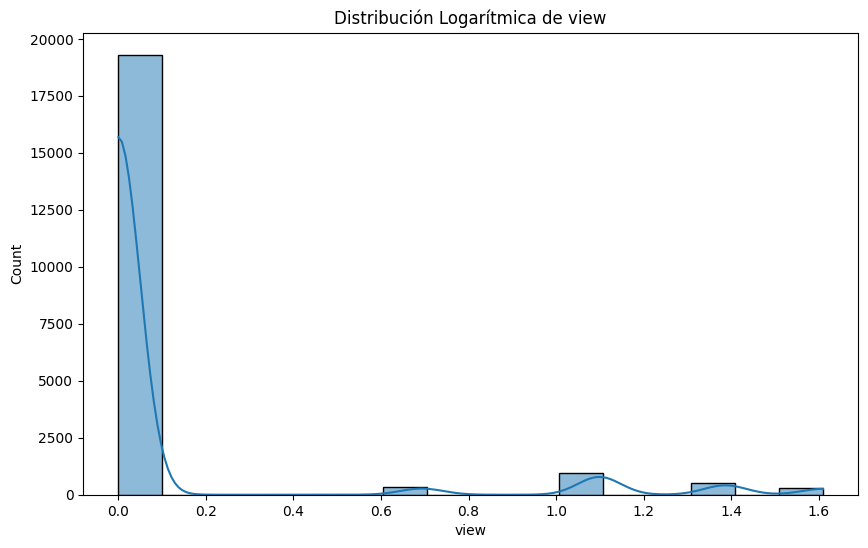

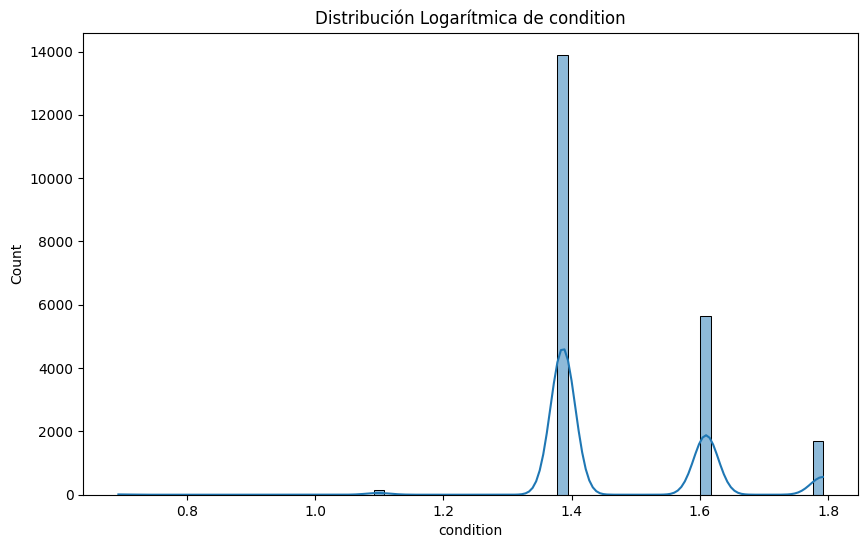

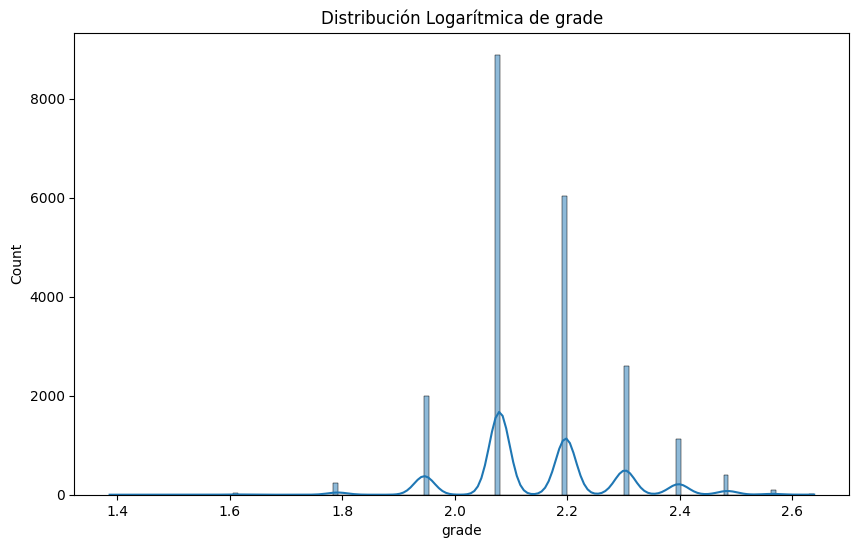

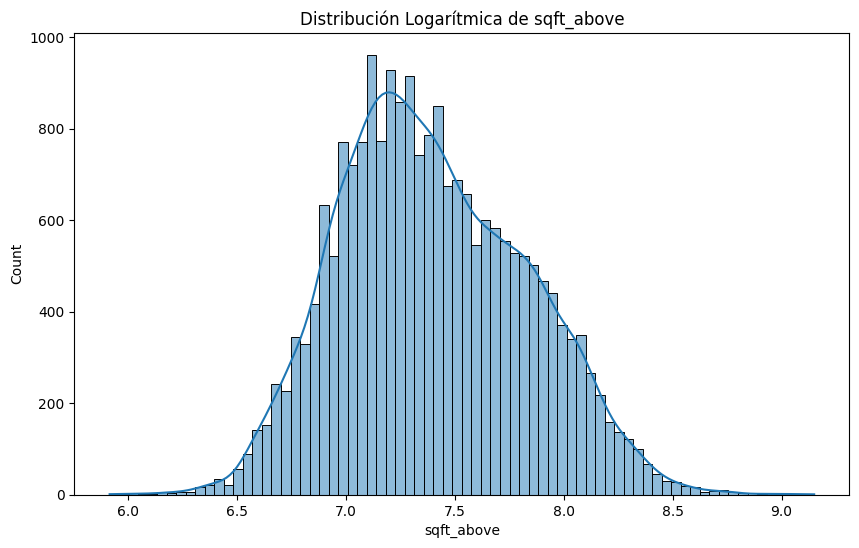

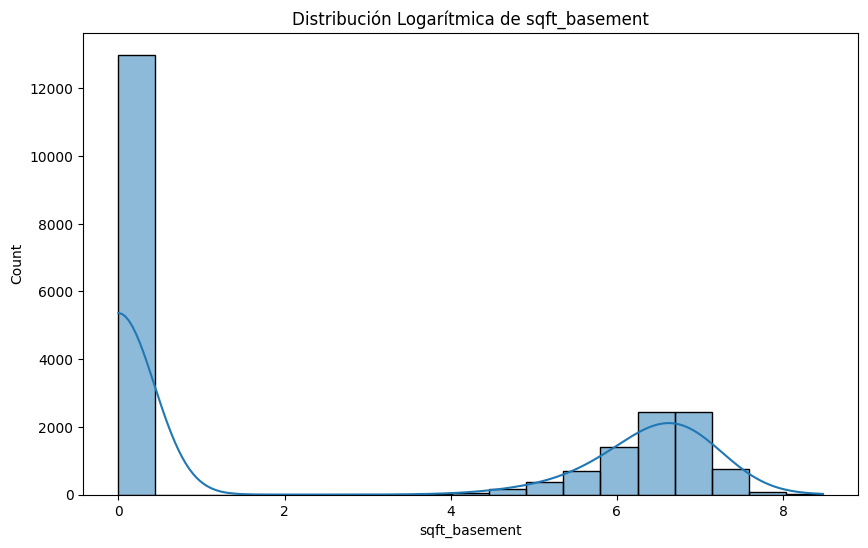

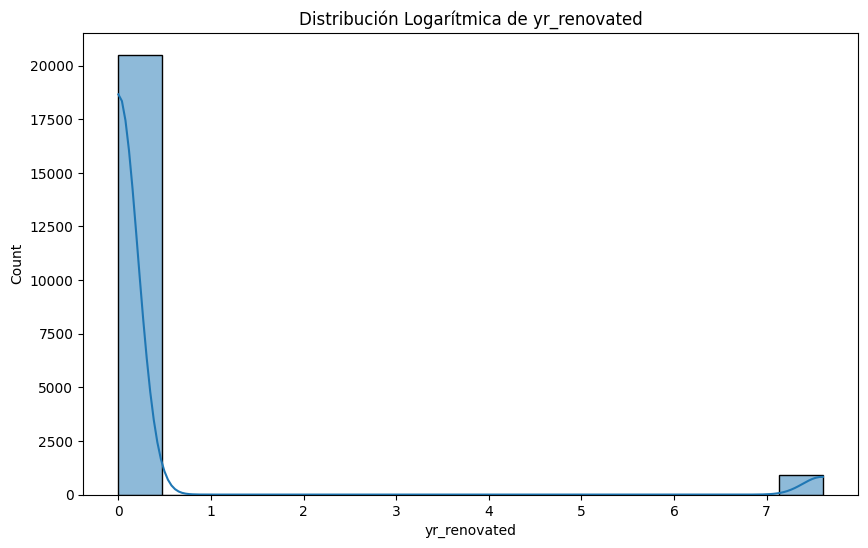

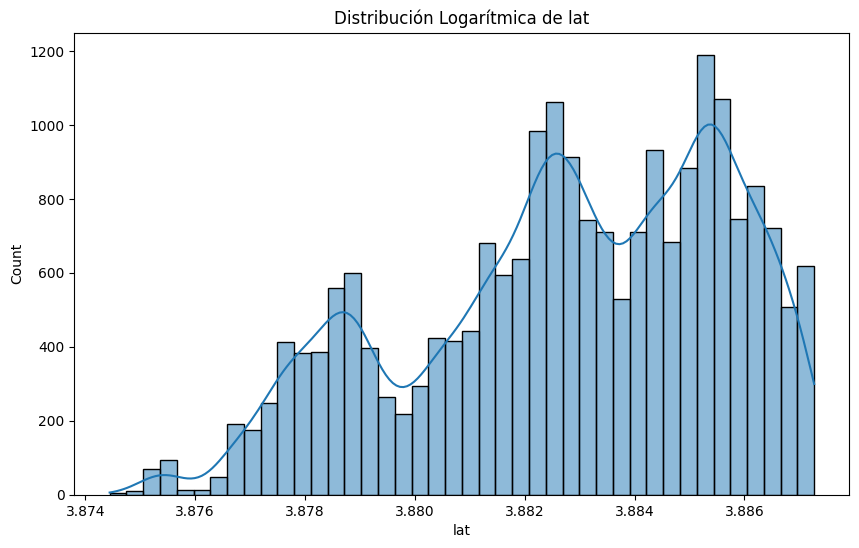

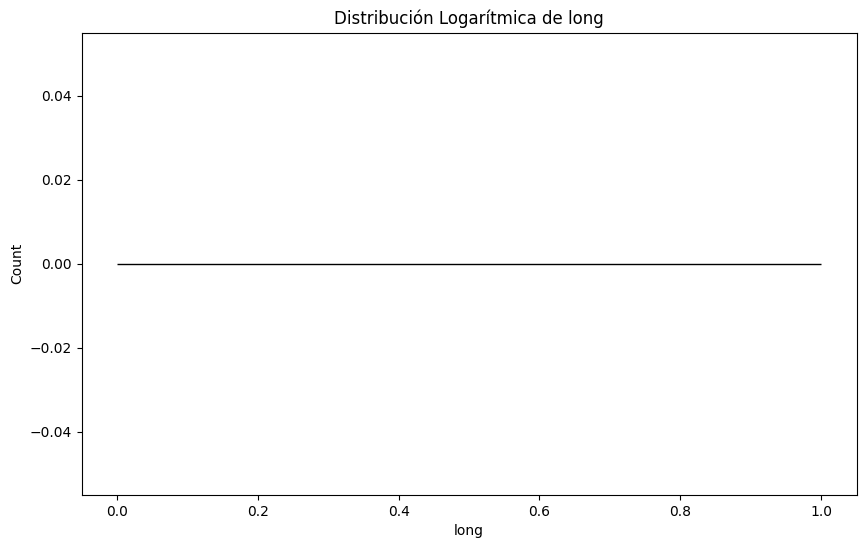

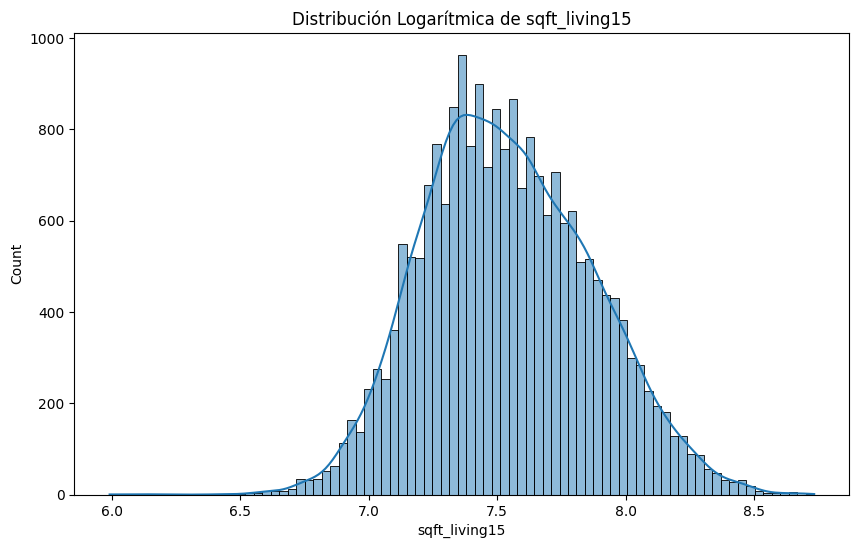

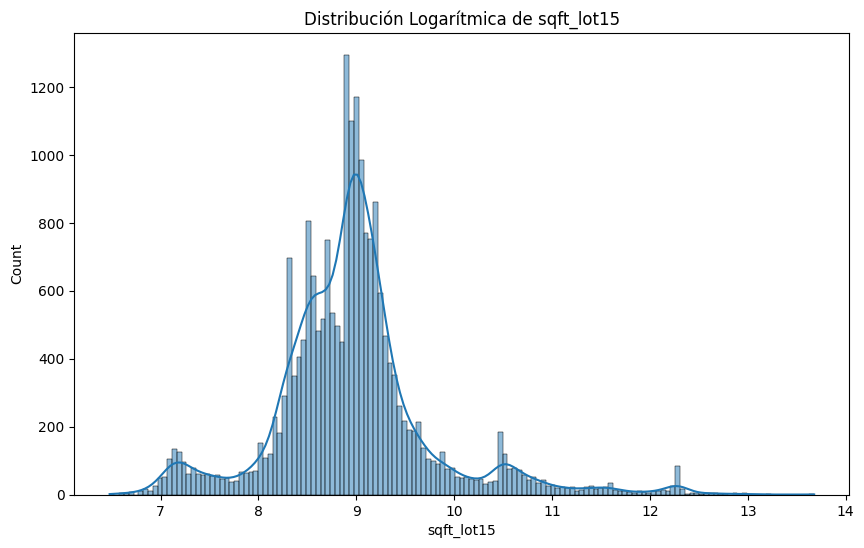

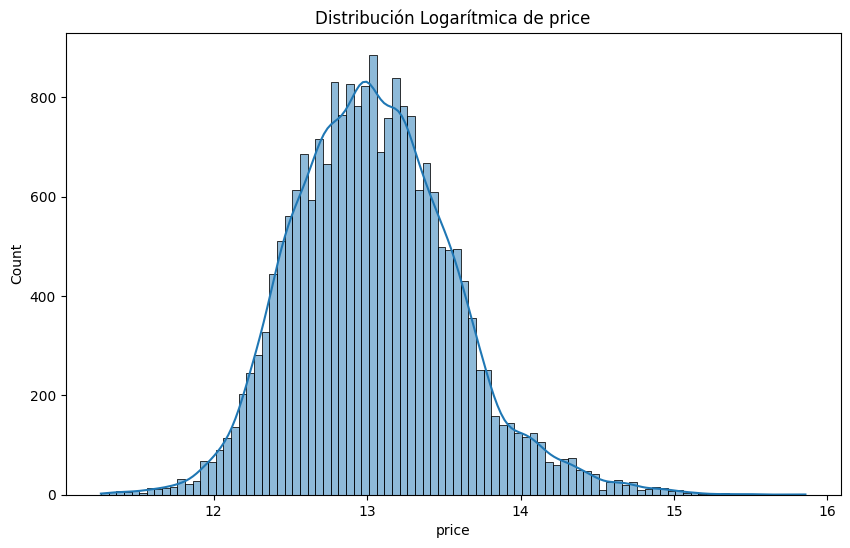

In [119]:
# Copiar el DataFrame original
df_log = df.copy()

# Lista de columnas a transformar
columnas_a_transformar = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                          'waterfront', 'view', 'condition', 'grade', 
                          'sqft_above', 'sqft_basement', 'yr_renovated', 
                          'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']

# Aplicar la transformación logarítmica (añadir 1 para evitar log(0))
for columna in columnas_a_transformar:
    df_log[columna] = np.log1p(df_log[columna])

# Verificar el resultado de la transformación
for columna in columnas_a_transformar:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_log[columna], kde=True)
    plt.title(f'Distribución Logarítmica de {columna}')
    plt.show()


In [120]:
# Transformar las columnas con outliers mediante una transformación logarítmica
columns_to_transform = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 
                        'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                        'sqft_living15', 'sqft_lot15', 'price']

# Evitar transformar valores de 0
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

# Verificar la transformación
df[columns_to_transform].describe()


,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
count,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000
mean,1.453934,1.106549,7.552722,8.989854,0.005275,0.116505,1.473932,2.150233,7.397247,2.532445,7.540962,8.960681,13.048917
std,0.210121,0.250664,0.423803,0.903716,0.060237,0.362839,0.140144,0.131808,0.426973,3.171484,0.327264,0.813957,0.526725
min,0.693147,0.405465,5.916202,6.255750,0.000000,0.000000,0.693147,1.386294,5.916202,0.000000,5.991465,6.480045,11.264477
25%,1.386294,1.011601,7.266129,8.525360,0.000000,0.000000,1.386294,2.079442,7.090910,0.000000,7.307202,8.537192,12.683862
50%,1.386294,1.178655,7.560601,8.937875,0.000000,0.000000,1.386294,2.079442,7.353082,0.000000,7.518064,8.938663,13.017005
75%,1.609438,1.252763,7.844241,9.277204,0.000000,0.000000,1.609438,2.197225,7.705713,6.329721,7.771067,9.219028,13.377007
max,3.526361,2.197225,9.513477,14.317110,0.693147,1.609438,1.791759,2.639057,9.149634,8.480737,8.734077,13.677628,15.856731


## 5. División de datos y preparación del modelo ##

In [125]:

# Separar características y target
X = df.drop(['price', 'id'], axis=1)
y = np.log1p(df['price'])

# Identificación de características categóricas y numéricas
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Ajustar el preprocesador en todo el conjunto de datos para obtener las características codificadas
preprocessor.fit(X)
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numerical_features + list(encoded_features)

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## 6. Entrenamiento y evaluación de modelos ##

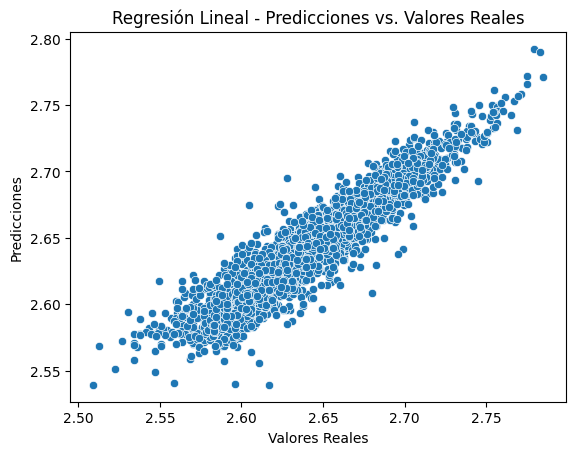

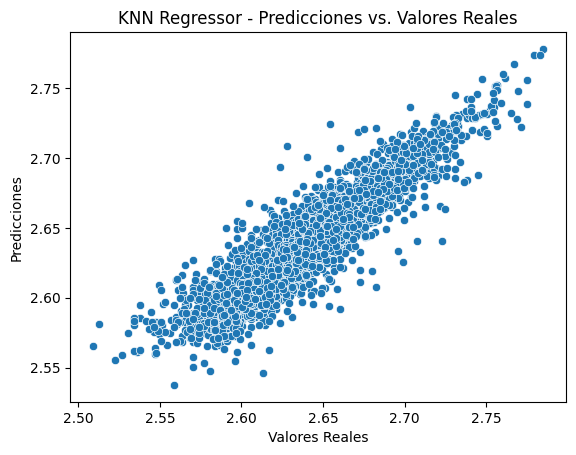

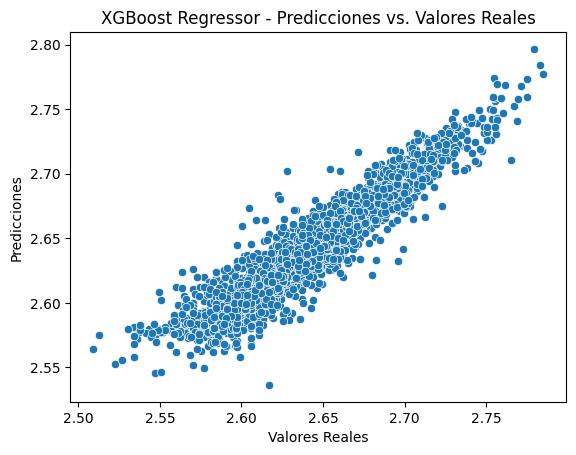

              Modelo       MSE        R²
0   Regresión Lineal  0.000172  0.875725
1      KNN Regressor  0.000213  0.846352
2  XGBoost Regressor  0.000150  0.891810


In [122]:


# Modelos
models = {
    'Regresión Lineal': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'XGBoost Regressor': xgb.XGBRegressor()
}

# Entrenar y evaluar modelos
results = []
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Modelo': model_name, 'MSE': mse, 'R²': r2})
    plt.figure()
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'{model_name} - Predicciones vs. Valores Reales')
    plt.show()

results_df = pd.DataFrame(results)
print(results_df)



Regresión Lineal:

MSE (Error Cuadrático Medio): 0.000332
R² (Coeficiente de Determinación): 0.759876
La regresión lineal muestra un rendimiento decente con un R² de aproximadamente 0.76, lo que indica que el modelo puede explicar el 76% de la variabilidad en los precios de las casas. Sin embargo, su MSE es el más alto entre los tres modelos, lo que sugiere que las predicciones tienen un mayor error en promedio.

KNN Regressor:

MSE (Error Cuadrático Medio): 0.000247
R² (Coeficiente de Determinación): 0.821375
El modelo KNN mejora en comparación con la regresión lineal, con un MSE más bajo y un R² más alto de aproximadamente 0.82. Esto indica que el modelo KNN es más preciso en sus predicciones y puede explicar mejor la variabilidad en los precios de las casas.

XGBoost Regressor:

MSE (Error Cuadrático Medio): 0.000152
R² (Coeficiente de Determinación): 0.890296
El modelo XGBoost es claramente el mejor de los tres, con el MSE más bajo y el R² más alto de aproximadamente 0.89. Esto significa que el modelo XGBoost tiene el menor error en promedio y puede explicar el 89% de la variabilidad en los precios de las casas.

Conclusiones
Mejor Modelo: XGBoost Regressor es el mejor modelo en términos de precisión y capacidad explicativa.
Siguientes Pasos: Podemos optimizar aún más el modelo XGBoost ajustando los hiperparámetros para mejorar su rendimiento.


## 7. Optimización del modelo XGBoost ##

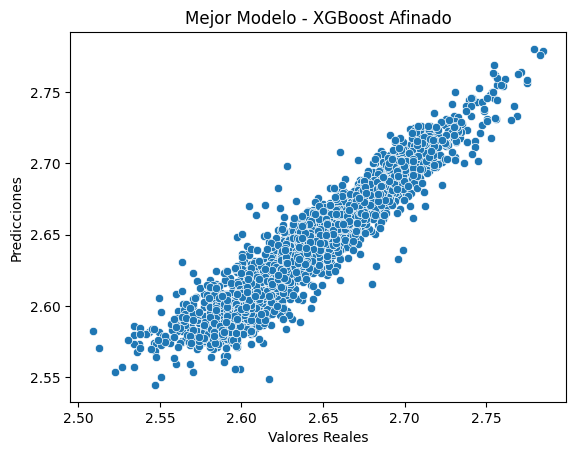

Mejor Modelo XGBoost Afinado - MSE: 0.00014058009551795906, R²: 0.8984127765475537


In [123]:

# Definir el grid de hiperparámetros para XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5, 7]
}

# Crear el pipeline con el preprocesador y el modelo XGBoost
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', xgb.XGBRegressor())])

# Realizar la búsqueda en el grid
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

# Obtener el mejor modelo
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Graficar los resultados del mejor modelo
plt.figure()
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Mejor Modelo - XGBoost Afinado')
plt.show()

# Evaluar el rendimiento del mejor modelo
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'Mejor Modelo XGBoost Afinado - MSE: {mse_xgb}, R²: {r2_xgb}')


## 8. Análisis de importancia de características ##

<Figure size 1200x800 with 0 Axes>

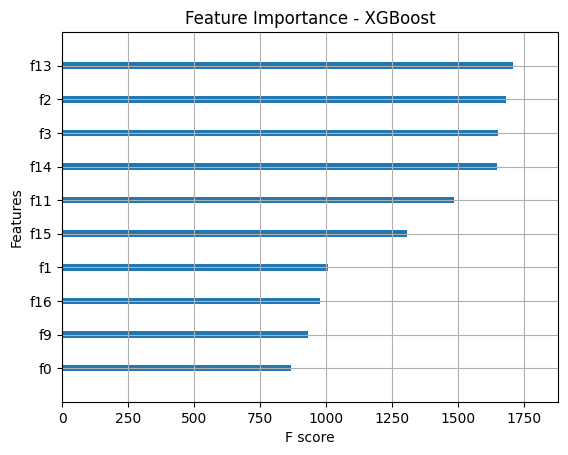

          Feature  Importance
8           grade    0.391230
13            lat    0.103909
2     sqft_living    0.072980
20  zipcode_98004    0.042499
5      waterfront    0.028284
..            ...         ...
57  zipcode_98092    0.001175
18  zipcode_98002    0.000969
31  zipcode_98024    0.000921
29  zipcode_98022    0.000000
52  zipcode_98070    0.000000

[87 rows x 2 columns]


In [126]:
# Obtener la importancia de las características
# Obtener el modelo XGBRegressor del pipeline afinado
xgb_regressor = best_xgb_model.named_steps['model']

# Graficar la importancia de las características con nombres
plt.figure(figsize=(12, 8))
plot_importance(xgb_regressor, max_num_features=10, importance_type='weight', show_values=False)
plt.title('Feature Importance - XGBoost')
plt.show()

# Mostrar los nombres de las características y sus importancias
importances = xgb_regressor.feature_importances_
feature_importances = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

## 9. Interpretación de resultados ##

### Grade: ###

Importancia: 0.391230

Grade parece ser la característica más influyente a la hora de determinar el precio de las viviendas. Sin embargo, no tenemos una idea demasiado exacta del sistema utilizado para determinar esta gradación; podemos suponer que hace referencia a calidad de los materiales, etc, pero no lo sabemos a ciencia cierta.

### Latitud (Lat): ###

Importancia: 0.103909

La latitud del inmueble también juega un papel significativo. Sería aconsejable realizar una cierta investigación sobre la zona: presencia de servicios, vistas, baja criminalidad...

### Superficie habitable (sqft_living): ###

Importancia: 0.072980

No es sorprendente que la superficie habitable de la vivienda sea una característica importante, sobre todo teniendo en cuenta que la concepción del uso del espacio (apuesta por superficies amplias, generalmente como símbolo de estatus) es casi un icono cultural norteamericano.

### Código postal 98004 (zipcode_98004): ###

Importancia: 0.042499

Este código postal parece indicar algún factor de cierta importancia. Dado que no conocemos la zona en profundidad, nos remitimos a lo dicho con respecto a la latitud.

### Waterfront ###

Importancia: 0.028284

Tener una propiedad frente al lago también añade algo de valor. Probablemente, por motivos estéticos y/o recreativos, así como de exhibición de estatus.